# 5. Covid-19 samples from healthy, mild and severe patients
Chen ST, Park MD, Del Valle DM, Buckup M, Tabachnikova A, Thompson RC, et al. A shift in lung macrophage composition is associated with COVID-19 severity and recovery. Sci Transl Med. 2022;14:eabn5168

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Scanpro functions
from scanpro import scanpro
from scanpro.get_transformed_props import get_transformed_props

In [2]:
# path where figures are going to be saved
FIG_PATH = 'plots'

In [3]:
def convert_counts_to_df(counts, prop_cols=None, meta_cols=None, n_cells=1, column_name="Cluster"):
    """ Convert a cell count matrix to a dataframe in long format."""

    counts = counts.copy()

    #If not given, try to get prop_cols and meta_cols automatically
    if prop_cols is None:
        dtypes = counts.dtypes.astype(str)
        prop_cols = [col for i, col in enumerate(counts.columns) if "float" in dtypes[i] or "int" in dtypes[i]]
        
    if meta_cols is None:
        meta_cols = [col for col in counts.columns if col not in prop_cols]

    # Multiply proportions with n_cells
    counts[prop_cols] *= n_cells
    counts[prop_cols] = counts[prop_cols].astype(int)
    
    # Melt into long format (similar to adata.obs)
    counts_melt = pd.melt(counts, id_vars=meta_cols, value_vars=prop_cols, 
                          var_name=column_name, value_name="count")

    # Duplicate rows based on number of cells
    counts_long = counts_melt.loc[counts_melt.index.repeat(counts_melt["count"])].reset_index(drop=True)
    counts_long.drop(columns="count", inplace=True)
    counts_long.index = ["cell_" + str(i) for i in range(1, len(counts_long) + 1)]
    
    return counts_long

------------------

## Read data

In [4]:
covid_counts = pd.read_csv("data/covid_counts.tsv", sep='\t')
covid = convert_counts_to_df(covid_counts, column_name="celltype")

In [5]:
covid

,Sample,Group,Disease,celltype
cell_1,HC1,Healthy,N,B cells
cell_2,HC1,Healthy,N,B cells
cell_3,HC1,Healthy,N,B cells
cell_4,HC1,Healthy,N,B cells
cell_5,HC1,Healthy,N,B cells
...,...,...,...,...
cell_65809,S2,Severe,Y,pDC
cell_65810,S2,Severe,Y,pDC
cell_65811,S2,Severe,Y,pDC
cell_65812,S4,Severe,Y,pDC


----------

## Run Scanpro

### Logit

In [6]:
out_covid_logit = scanpro.scanpro(covid, clusters_col='celltype', 
                                         conds_col='Group', samples_col='Sample')
out_covid_logit.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_Healthy,mean_props_Mild,mean_props_Severe,f_statistics,p_values,adjusted_p_values
B cells,0.003343,0.003503,0.012990,0.004005,2.593405,0.074765,0.106807
Epithelial,0.053652,0.130246,0.051903,0.118455,1.536041,0.215232,0.249978
Macrophages,0.750870,0.735290,0.512996,0.604316,1.491742,0.224980,0.249978
Mast,0.001064,0.002337,0.002220,0.001699,1.164873,0.311962,0.311962
NK cells,0.016425,0.008894,0.052466,0.017979,4.841923,0.007892,0.026306
Neutrophil,0.024418,0.000000,0.001204,0.055594,92.441438,0.000000,0.000000
Plasma,0.015818,0.000224,0.002150,0.050913,10.404122,0.000030,0.000152
T cells,0.117241,0.094594,0.325030,0.137097,3.081910,0.045872,0.084251
mDC,0.014860,0.023776,0.030831,0.008876,2.984785,0.050550,0.084251
pDC,0.002310,0.001134,0.008210,0.001066,4.023778,0.017885,0.044713


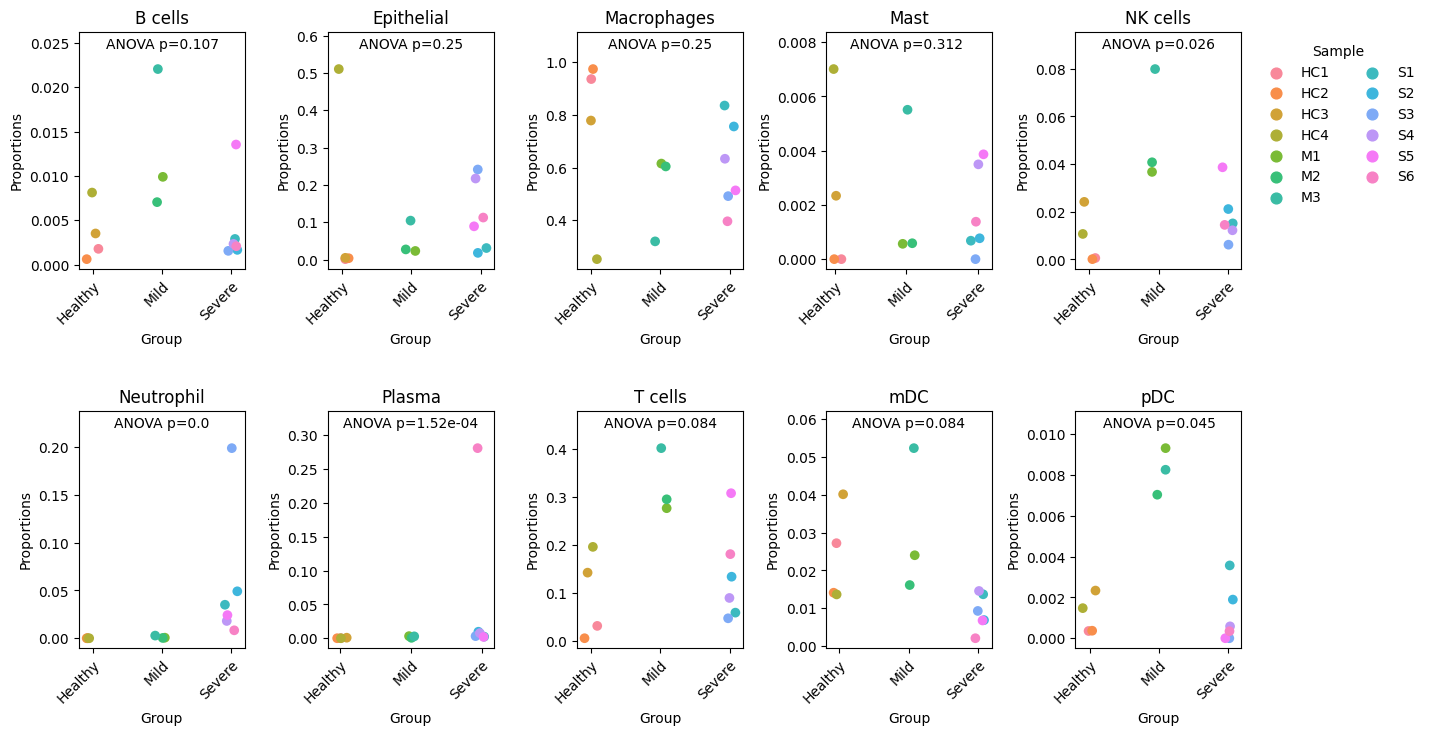

In [7]:
out_covid_logit.plot(n_columns=5, save=f"{FIG_PATH}/covid19_boxplot.pdf")

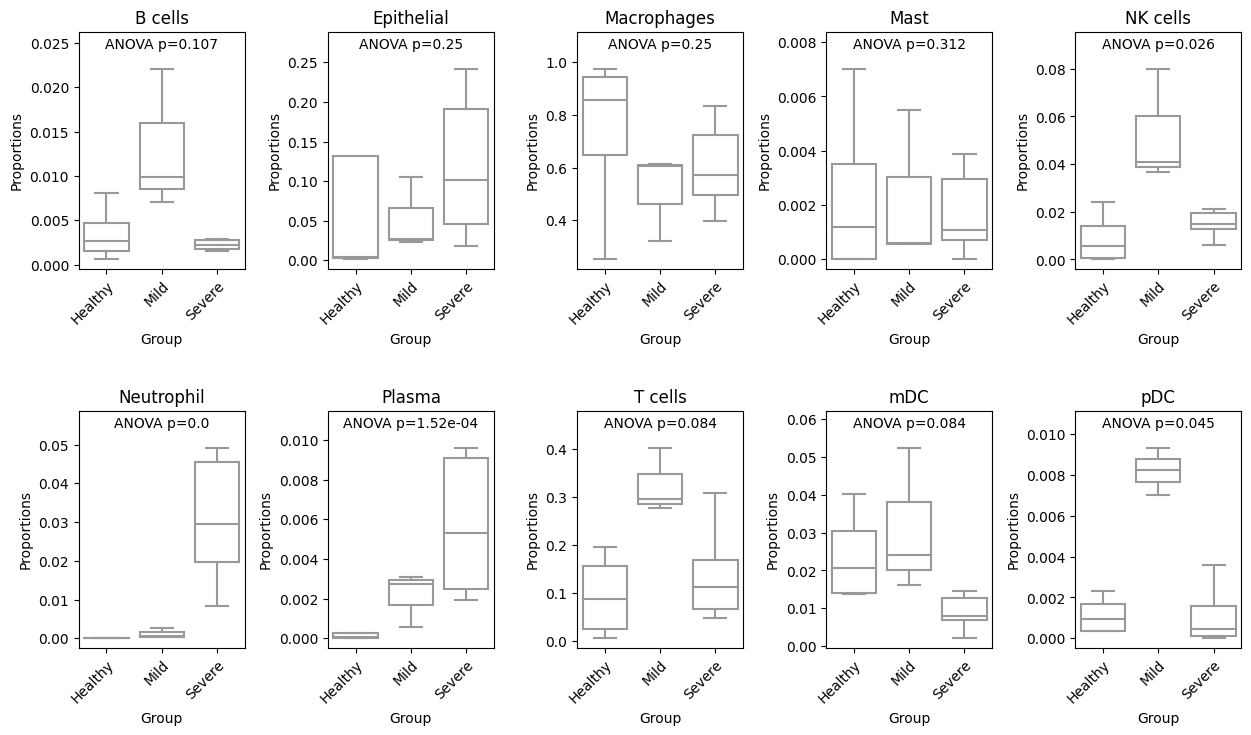

In [8]:
out_covid_logit.plot(kind='boxplot', n_columns=5, save=f"{FIG_PATH}/covid19_boxplot.pdf")

In [9]:
out_covid_logit.results.to_csv("results/covid_scanpro_rep_logit.tsv", sep="\t")

### arcsin

In [10]:
out_covid_arcsin = scanpro.scanpro(covid, clusters_col='celltype', samples_col='Sample',
                                   conds_col='Group', transform='arcsin')
out_covid_arcsin.results

[INFO] There are more than 2 conditions. ANOVA will be performed...
[INFO] Done!


,baseline_props,mean_props_Healthy,mean_props_Mild,mean_props_Severe,f_statistics,p_values,adjusted_p_values
B cells,0.003343,0.003503,0.012990,0.004005,3.200032,0.040761,0.067935
Epithelial,0.053652,0.130246,0.051903,0.118455,0.310040,0.733418,0.814908
Macrophages,0.750870,0.735290,0.512996,0.604316,1.237913,0.289989,0.362486
Mast,0.001064,0.002337,0.002220,0.001699,0.042212,0.958667,0.958667
NK cells,0.016425,0.008894,0.052466,0.017979,7.534890,0.000534,0.001780
Neutrophil,0.024418,0.000000,0.001204,0.055594,7.709304,0.000449,0.001780
Plasma,0.015818,0.000224,0.002150,0.050913,1.387393,0.249726,0.356751
T cells,0.117241,0.094594,0.325030,0.137097,5.454035,0.004279,0.010698
mDC,0.014860,0.023776,0.030831,0.008876,5.055541,0.006374,0.012748
pDC,0.002310,0.001134,0.008210,0.001066,7.893592,0.000373,0.001780


In [11]:
out_covid_arcsin.results.to_csv("results/covid_scanpro_rep_arcsin.tsv", sep="\t")

----------

## Without replicates

### Logit

In [12]:
out_covid_boot_logit = scanpro.scanpro(covid, clusters_col='celltype',
                                       conds_col='Group', n_reps=8)

out_covid_boot_logit.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[WARNING] Consider setting transform='arcsin', as this produces more accurate results for simulated data.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 13.43 seconds


,baseline_props,mean_props_Healthy,mean_props_Mild,mean_props_Severe,p_values
B cells,0.003343,0.001372,0.007502,0.001958,1.349471e-01
Epithelial,0.053652,0.061720,0.026265,0.045819,2.991314e-01
Macrophages,0.750870,0.850207,0.599225,0.727359,2.411694e-02
Mast,0.001064,0.000523,0.000415,0.000592,4.832450e-01
NK cells,0.016425,0.003145,0.036964,0.015301,7.049451e-03
Neutrophil,0.024418,0.000000,0.000249,0.038975,2.567539e-09
Plasma,0.015818,0.000034,0.001086,0.023123,3.773859e-06
T cells,0.117241,0.051069,0.285230,0.118617,3.177709e-03
mDC,0.014860,0.019081,0.019148,0.007420,2.816998e-01
pDC,0.002310,0.000363,0.005934,0.001245,3.646589e-02


In [13]:
out_covid_boot_logit.results.to_csv("results/covid_scanpro_norep_logit.tsv", sep="\t")

### Arcsin

In [14]:
out_covid_boot_arcsin = scanpro.scanpro(covid, clusters_col='celltype',
                                       conds_col='Group', n_reps=8, transform='arcsin')

out_covid_boot_arcsin.results

[INFO] Your data doesn't have replicates! Artificial replicates will be simulated to run scanpro.
[INFO] Simulation may take some minutes...
[INFO] Generating 8 replicates and running 100 simulations...
[INFO] Finished 100 simulations in 12.93 seconds


,baseline_props,mean_props_Healthy,mean_props_Mild,mean_props_Severe,p_values
B cells,0.003343,0.001400,0.007493,0.001976,9.790488e-02
Epithelial,0.053652,0.061655,0.026211,0.045517,1.240456e-01
Macrophages,0.750870,0.850725,0.598391,0.726995,7.176954e-05
Mast,0.001064,0.000519,0.000413,0.000593,6.535668e-01
NK cells,0.016425,0.003127,0.036653,0.015235,6.636199e-04
Neutrophil,0.024418,0.000000,0.000249,0.038993,1.778270e-09
Plasma,0.015818,0.000035,0.001070,0.023040,2.119768e-06
T cells,0.117241,0.051025,0.286811,0.118593,3.486753e-07
mDC,0.014860,0.019017,0.019148,0.007329,1.731609e-01
pDC,0.002310,0.000363,0.005911,0.001208,2.406277e-02


In [15]:
out_covid_boot_arcsin.results.to_csv("results/covid_scanpro_norep_arcsin.tsv", sep="\t")

#### Plasma cells have one sample as outlier, which affects the bootstrapping result

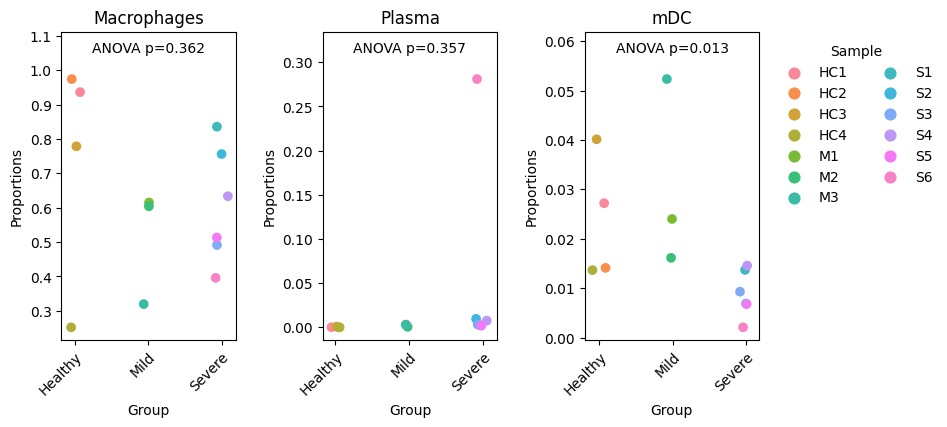

In [16]:
out_covid_arcsin.plot(n_columns=5, clusters=['Macrophages', 'Plasma', 'mDC'],
                      save=f'{FIG_PATH}/covid_stripplot_example.pdf')

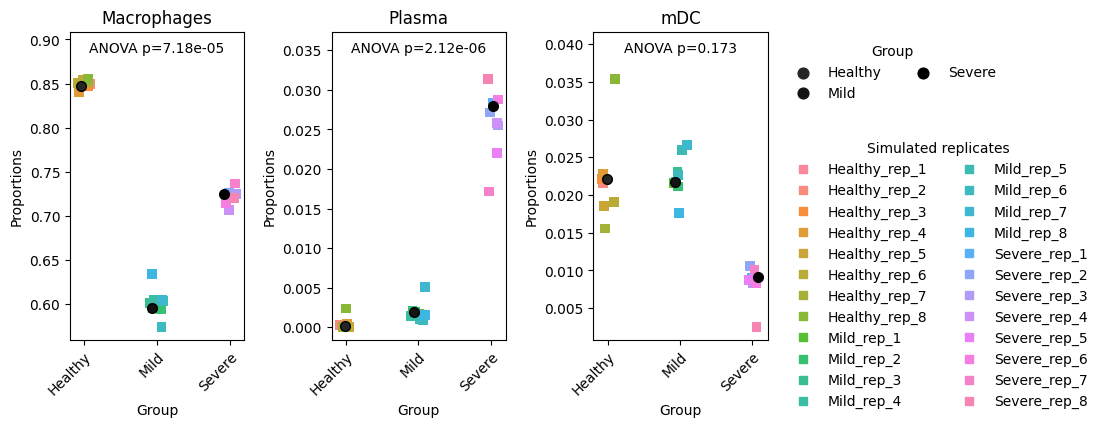

In [17]:
out_covid_boot_arcsin.plot(clusters=['Macrophages', 'Plasma', 'mDC'],
                           save=f'{FIG_PATH}/covid_stripplot_norep_example.pdf')

-----------------

# Run propeller

In [18]:
# Setup path to R
R_home = os.path.dirname(sys.executable)[:-4] + "/lib/R"
os.environ["R_HOME"] = R_home
%load_ext rpy2.ipython

In [19]:
%%R -i covid -o propeller_results_logit -o propeller_results_arcsin
library(speckle)

propeller_results_logit = propeller(clusters = covid$celltype, sample = covid$Sample, group = covid$Group, 
                                    transform = "logit")

propeller_results_arcsin = propeller(clusters = covid$celltype, sample = covid$Sample, group = covid$Group, 
                                    transform = "asin")


    an issue that caused a segfault when used with rpy2:
    https://github.com/rstudio/reticulate/pull/1188
    Make sure that you use a version of that package that includes
    the fix.
    

The legacy packages maptools, rgdal, and rgeos, underpinning this package
will retire shortly. Please refer to R-spatial evolution reports on
https://r-spatial.org/r/2023/05/15/evolution4.html for details.
This package is now running under evolution status 0 
Performing logit transformation of proportions
group variable has > 2 levels, ANOVA will be performed
Performing arcsin square root transformation of proportions
group variable has > 2 levels, ANOVA will be performed


In [20]:
propeller_results_logit

,BaselineProp,PropMean.Healthy,PropMean.Mild,PropMean.Severe,Fstatistic,P.Value,FDR
Neutrophil,0.024418,-0.000000,0.001204,0.055594,34.534717,3.546468e-07,0.000004
Plasma,0.015818,0.000224,0.002150,0.050913,8.718137,2.056673e-03,0.010283
pDC,0.002310,0.001134,0.008210,0.001066,5.785273,1.052218e-02,0.034935
NK cells,0.016425,0.008894,0.052466,0.017979,5.391241,1.397389e-02,0.034935
T cells,0.117241,0.094594,0.325030,0.137097,3.155124,6.468749e-02,0.129375
mDC,0.014860,0.023776,0.030831,0.008876,2.484229,1.090338e-01,0.167374
B cells,0.003343,0.003503,0.012990,0.004005,2.394586,1.171617e-01,0.167374
Epithelial,0.053652,0.130246,0.051903,0.118455,1.813467,1.901866e-01,0.237733
Macrophages,0.750870,0.735290,0.512996,0.604316,1.620740,2.239111e-01,0.248790
Mast,0.001064,0.002337,0.002220,0.001699,0.692073,5.127128e-01,0.512713


In [21]:
propeller_results_arcsin

,BaselineProp,PropMean.Healthy,PropMean.Mild,PropMean.Severe,Fstatistic,P.Value,FDR
pDC,0.002310,0.001134,0.008210,0.001066,7.668004,0.007892,0.028010
Neutrophil,0.024418,-0.000000,0.001204,0.055594,7.699773,0.008007,0.028010
NK cells,0.016425,0.008894,0.052466,0.017979,7.520691,0.008403,0.028010
T cells,0.117241,0.094594,0.325030,0.137097,5.377659,0.023311,0.054665
mDC,0.014860,0.023776,0.030831,0.008876,5.037225,0.027333,0.054665
B cells,0.003343,0.003503,0.012990,0.004005,3.180201,0.080297,0.133829
Plasma,0.015818,0.000224,0.002150,0.050913,1.379356,0.291777,0.415445
Macrophages,0.750870,0.735290,0.512996,0.604316,1.218630,0.332356,0.415445
Epithelial,0.053652,0.130246,0.051903,0.118455,0.305296,0.742907,0.825452
Mast,0.001064,0.002337,0.002220,0.001699,0.046515,0.954732,0.954732


In [22]:
propeller_results_logit.to_csv("results/covid_propeller_rep_logit.tsv", sep="\t")
propeller_results_arcsin.to_csv("results/covid_propeller_rep_arcsin.tsv", sep="\t")

-----------------

# Run scCODA

In [23]:
import pertpy as pt
import anndata as ad

Global seed set to 0
/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/mbentse/.conda/envs/scanpro_analysis/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [24]:
sccoda_adata = ad.AnnData(obs=covid)

## With replicates

In [25]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="celltype", 
                                sample_identifier="Sample", covariate_obs=["Group"])
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="Group", reference_cell_type="Mast")

Zero counts encountered in data! Added a pseudocount of 0.5.

In [26]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
sample: 100%|██████████| 11000/11000 [03:05<00:00, 59.36it/s, 255 steps of size 1.99e-02. acc. prob=0.85]


In [27]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.2)
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌────────────────────────────────────────────┬────────────────────────────────────────────────────────────────────┐
│ Name                                       │ Value                                                              │
├────────────────────────────────────────────┼────────────────────────────────────────────────────────────────────┤
│ Data                                       │ Data: 13 samples, 10 cell types                                    │
│ Reference cell type                        │ Mast                                                               │
│ Formula                                    │ Group                                                              │
└────────────────────────────────────────────┴────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│              Final Parameter  Expected Sample                                                                   │
│ Cell Type                                                                                                       │
│ B cells          -1.102           123.180                                                                       │
│ Epithelial       -0.243           290.802                                                                       │
│ Macrophages       2.197          3336.387                                                                       │
│ Mast             -1.468            85.425                                                                       │
│ NK cells         -0.818           163.636                                                                       │
│ Neutrophil       -1.490            83.567                                                                       │
│ Plasma           -1.432            88.557                                                                       │
│ T cells           0.453           583.266                                                                       │
│ mDC              -0.535           217.162                                                                       │
│ pDC              -1.405            90.980                                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                            Final Parameter  Expected Sample  log2-fold change                                   │
│ Covariate     Cell Type                                                                                         │
│ GroupT.Mild   B cells          0.000             93.135           -0.403                                        │
│               Epithelial       0.000            219.873           -0.403                                        │
│               Macrophages      0.000           2522.607           -0.403                                        │
│               Mast             0.000             64.589           -0.403                                        │
│               NK cells         0.792            273.115            0.739                                        │
│               Neutrophil       0.000             63.184           -0.403                                        │
│               Plasma           0.000             66.957           -0.403                                        │
│               T cells          1.242           1526.519            1.388                                        │
│               mDC              0.000            164.194           -0.403                                        │
│               pDC              0.000             68.789           -0.403                                        │
│ GroupT.Severe B cells          0.000            114.162           -0.110                                        │
│               Epithelial       0.622            502.090            0.788                                        │
│               Macrophages      0.000           3092.132           -0.110                                        │
│               Mast             0.000             79.171           -0.110                                        │
│               NK cells         0.000            151.656           -0.110                                        │
│               Neutrophil       1.023            215.528            1.367                                        │
│               Plasma           0.000             82.074           -0.110                                        │
│               T cells          0.000            540.566           -0.110                                        │
│               mDC              0.000            201.264           -0.110                                        │
│               pDC              0.000             84.320           -0.110                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [28]:
credible_effects = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
credible_effects

credible_effect
Covariate       Cell Type                   
Group[T.Mild]   B cells                False
                Epithelial             False
                Macrophages            False
                Mast                   False
                NK cells                True
                Neutrophil             False
                Plasma                 False
                T cells                 True
                mDC                    False
                pDC                    False
Group[T.Severe] B cells                False
                Epithelial              True
                Macrophages            False
                Mast                   False
                NK cells               False
                Neutrophil              True
                Plasma                 False
                T cells                False
                mDC                    False
                pDC                    False

In [29]:
credible_effects.to_csv("results/covid_sccoda_rep.tsv", sep="\t")

## Without replicates

In [30]:
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(sccoda_adata, type="cell_level", generate_sample_level=True, cell_type_identifier="celltype", 
                                sample_identifier="Group", covariate_obs=["Group"])
sccoda_data = sccoda_model.prepare(sccoda_data, modality_key="coda", formula="Group", reference_cell_type="Mast")

Zero counts encountered in data! Added a pseudocount of 0.5.

In [31]:
sccoda_model.run_nuts(sccoda_data, modality_key="coda")

sample: 100%|██████████| 11000/11000 [01:04<00:00, 169.24it/s, 255 steps of size 1.53e-02. acc. prob=0.71]


In [32]:
sccoda_model.set_fdr(sccoda_data, modality_key="coda", est_fdr=0.2)
sccoda_model.summary(sccoda_data, modality_key="coda")

                                          Compositional Analysis summary                                           
┌─────────────────────────────────────────────┬───────────────────────────────────────────────────────────────────┐
│ Name                                        │ Value                                                             │
├─────────────────────────────────────────────┼───────────────────────────────────────────────────────────────────┤
│ Data                                        │ Data: 3 samples, 10 cell types                                    │
│ Reference cell type                         │ Mast                                                              │
│ Formula                                     │ Group                                                             │
└─────────────────────────────────────────────┴───────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Intercepts                                                                                                      │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│              Final Parameter  Expected Sample                                                                   │
│ Cell Type                                                                                                       │
│ B cells           0.164           105.286                                                                       │
│ Epithelial        2.616          1222.531                                                                       │
│ Macrophages       5.316         18190.927                                                                       │
│ Mast             -0.533            52.440                                                                       │
│ NK cells          0.939           228.532                                                                       │
│ Neutrophil       -1.068            30.713                                                                       │
│ Plasma           -0.647            46.790                                                                       │
│ T cells           2.867          1571.331                                                                       │
│ mDC               1.539           416.413                                                                       │
│ pDC              -0.204            72.870                                                                       │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┐
│ Effects                                                                                                         │
├─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤
│                            Final Parameter  Expected Sample  log2-fold change                                   │
│ Covariate     Cell Type                                                                                         │
│ GroupT.Mild   B cells          0.000             87.995           -0.259                                        │
│               Epithelial       0.000           1021.763           -0.259                                        │
│               Macrophages      0.000          15203.552           -0.259                                        │
│               Mast             0.000             43.829           -0.259                                        │
│               NK cells         1.084            564.607            1.305                                        │
│               Neutrophil       0.000             25.669           -0.259                                        │
│               Plasma           0.000             39.106           -0.259                                        │
│               T cells          1.241           4542.381            1.531                                        │
│               mDC              0.000            348.028           -0.259                                        │
│               pDC              0.000             60.903           -0.259                                        │
│ GroupT.Severe B cells          0.000            100.259           -0.071                                        │
│               Epithelial       0.000           1164.160           -0.071                                        │
│               Macrophages      0.000          17322.392           -0.071                                        │
│               Mast             0.000             49.937           -0.071                                        │
│               NK cells         0.000            217.621           -0.071                                        │
│               Neutrophil       3.093            644.370            4.391                                        │
│               Plasma           2.370            476.865            3.349                                        │
│               T cells          0.000           1496.307           -0.071                                        │
│               mDC              0.000            396.531           -0.071                                        │
│               pDC              0.000             69.391           -0.071                                        │
└─────────────────────────────────────────────────────────────────────────────────────────────────────────────────┘

In [33]:
credible_effects = sccoda_model.credible_effects(sccoda_data, modality_key="coda").to_frame(name="credible_effect")
credible_effects

credible_effect
Covariate       Cell Type                   
Group[T.Mild]   B cells                False
                Epithelial             False
                Macrophages            False
                Mast                   False
                NK cells                True
                Neutrophil             False
                Plasma                 False
                T cells                 True
                mDC                    False
                pDC                    False
Group[T.Severe] B cells                False
                Epithelial             False
                Macrophages            False
                Mast                   False
                NK cells               False
                Neutrophil              True
                Plasma                  True
                T cells                False
                mDC                    False
                pDC                    False

In [34]:
credible_effects.to_csv("results/covid_sccoda_norep.tsv", sep="\t")